## Census Undercount

Census Undercount in absolute terms is relatively small historically. However, it disproportionally-affects vulnerable populations. For those populations, undercount rates are much higher

Traditionally Mail Return Rate of the Census survey is used as a proxy variable for the population undercount measure at the block level.

The following variables are found to play a major role in explaining the measure


1.  Percentage of the renter occupied units (+)
2.  Total Population between 18 and 24 years of age (+)
3.  Number of Female Households, No husbands (+)
4.  Non Hispanic, White Alone population (-)
5.  Total Population above 65 years (+)


### Setup

Connect to OmniSci database using standard credentials

In [15]:
con=omnisci_connect()

The 'con' variable above returns an Ibis connection, also for convenience and clarity, create a pymapd connection.

In [16]:
pymapd_con =con.con

Install mlflow if needed (should come standard with most recent OmniSci installs)

In [17]:
#!pip3 install mlflow

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import warnings
import sys

In [19]:
import mlflow
from mlflow import sklearn

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.metrics import accuracy_score,r2_score

In [21]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier,XGBRegressor

### Importing Data

In [22]:
data_table=pd.read_csv("pdb2014bgv9_us.csv",engine='python',thousands=',')

In [24]:
data_table["State_name"].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming',
       'Puerto Rico Commonwealth'], dtype=object)

Clean up columns which have dollar signs and commas

In [25]:
data_table['Med_HHD_Inc_BG_ACS_08_12'] = data_table['Med_HHD_Inc_BG_ACS_08_12'].str.replace('$', '')
data_table['Med_HHD_Inc_BG_ACS_08_12'] = data_table['Med_HHD_Inc_BG_ACS_08_12'].str.replace(',', '')

data_table['Med_HHD_Inc_BG_ACSMOE_08_12'] = data_table['Med_HHD_Inc_BG_ACSMOE_08_12'].str.replace('$', '')
data_table['Med_HHD_Inc_BG_ACSMOE_08_12'] = data_table['Med_HHD_Inc_BG_ACSMOE_08_12'].str.replace(',', '')

data_table['Med_HHD_Inc_TR_ACS_08_12'] = data_table['Med_HHD_Inc_TR_ACS_08_12'].str.replace('$', '')
data_table['Med_HHD_Inc_TR_ACS_08_12'] = data_table['Med_HHD_Inc_TR_ACS_08_12'].str.replace(',', '')

data_table['Med_HHD_Inc_TR_ACSMOE_08_12'] = data_table['Med_HHD_Inc_TR_ACSMOE_08_12'].str.replace('$', '')
data_table['Med_HHD_Inc_TR_ACSMOE_08_12'] = data_table['Med_HHD_Inc_TR_ACSMOE_08_12'].str.replace(',', '')

data_table['Aggregate_HH_INC_ACS_08_12'] = data_table['Aggregate_HH_INC_ACS_08_12'].str.replace('$', '')
data_table['Aggregate_HH_INC_ACS_08_12'] = data_table['Aggregate_HH_INC_ACS_08_12'].str.replace(',', '')

data_table['Aggregate_HH_INC_ACSMOE_08_12'] = data_table['Aggregate_HH_INC_ACSMOE_08_12'].str.replace('$', '')
data_table['Aggregate_HH_INC_ACSMOE_08_12'] = data_table['Aggregate_HH_INC_ACSMOE_08_12'].str.replace(',', '')

data_table['Med_House_Value_BG_ACS_08_12'] = data_table['Med_House_Value_BG_ACS_08_12'].str.replace('$', '')
data_table['Med_House_Value_BG_ACS_08_12'] = data_table['Med_House_Value_BG_ACS_08_12'].str.replace(',', '')

data_table['Med_House_Value_BG_ACSMOE_08_12'] = data_table['Med_House_Value_BG_ACSMOE_08_12'].str.replace('$', '')
data_table['Med_House_Value_BG_ACSMOE_08_12'] = data_table['Med_House_Value_BG_ACSMOE_08_12'].str.replace(',', '')

data_table['Med_house_value_tr_ACS_08_12'] = data_table['Med_house_value_tr_ACS_08_12'].str.replace('$', '')
data_table['Med_house_value_tr_ACS_08_12'] = data_table['Med_house_value_tr_ACS_08_12'].str.replace(',', '')

data_table['Med_house_value_tr_ACSMOE_08_12'] = data_table['Med_house_value_tr_ACSMOE_08_12'].str.replace('$', '')
data_table['Med_house_value_tr_ACSMOE_08_12'] = data_table['Med_house_value_tr_ACSMOE_08_12'].str.replace(',', '')

data_table['Aggr_House_Value_ACS_08_12'] = data_table['Aggr_House_Value_ACS_08_12'].str.replace('$', '')
data_table['Aggr_House_Value_ACS_08_12'] = data_table['Aggr_House_Value_ACS_08_12'].str.replace(',', '')

data_table['Aggr_House_Value_ACSMOE_08_12'] = data_table['Aggr_House_Value_ACSMOE_08_12'].str.replace('$', '')
data_table['Aggr_House_Value_ACSMOE_08_12'] = data_table['Aggr_House_Value_ACSMOE_08_12'].str.replace(',', '')


Force column types

In [26]:
data_table['GIDBG']=data_table['GIDBG'].astype(str)
data_table['State']=data_table['State'].astype(str)
data_table['State_name']=data_table['State_name'].astype(str)
data_table['County']=data_table['County'].astype(str)
data_table['County_name']=data_table['County_name'].astype(str)
data_table['Tract']=data_table['Tract'].astype(str)
data_table['Block_Group']=data_table['Block_Group'].astype(str)

data_table['Med_HHD_Inc_BG_ACS_08_12']=data_table['Med_HHD_Inc_BG_ACS_08_12'].notnull().astype(int)
data_table['Med_HHD_Inc_BG_ACSMOE_08_12']=data_table['Med_HHD_Inc_BG_ACSMOE_08_12'].notnull().astype(int)
data_table['Med_HHD_Inc_TR_ACS_08_12']=data_table['Med_HHD_Inc_TR_ACS_08_12'].notnull().astype(int)
data_table['Med_HHD_Inc_TR_ACSMOE_08_12']=data_table['Med_HHD_Inc_TR_ACSMOE_08_12'].notnull().astype(int)
data_table['Aggregate_HH_INC_ACS_08_12']=data_table['Aggregate_HH_INC_ACS_08_12'].notnull().astype(int)
data_table['Aggregate_HH_INC_ACSMOE_08_12']=data_table['Aggregate_HH_INC_ACSMOE_08_12'].notnull().astype(int)
data_table['Med_House_Value_BG_ACS_08_12']=data_table['Med_House_Value_BG_ACS_08_12'].notnull().astype(int)
data_table['Med_House_Value_BG_ACSMOE_08_12']=data_table['Med_House_Value_BG_ACSMOE_08_12'].notnull().astype(int)
data_table['Med_house_value_tr_ACS_08_12']=data_table['Med_house_value_tr_ACS_08_12'].notnull().astype(int)
data_table['Med_house_value_tr_ACSMOE_08_12']=data_table['Med_house_value_tr_ACSMOE_08_12'].notnull().astype(int)
data_table['Aggr_House_Value_ACS_08_12']=data_table['Aggr_House_Value_ACS_08_12'].notnull().astype(int)
data_table['Aggr_House_Value_ACSMOE_08_12']=data_table['Aggr_House_Value_ACSMOE_08_12'].notnull().astype(int)


In [27]:
data_table.head()

,GIDBG,State,State_name,County,County_name,Tract,Block_Group,Flag,LAND_AREA,AIAN_LAND,...,pct_TEA_MailOutMailBack_CEN_2010,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacant_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010
0,10010201001,1,Alabama,1,Autauga County,20100,1,NaN,1.638,0.0,...,100.0,0.0,62.13,3.65,0.0,19.93,76.41,54.49,7.64,0.0
1,10010201002,1,Alabama,1,Autauga County,20100,2,NaN,2.150,0.0,...,100.0,0.0,72.08,0.83,0.0,14.17,85.00,66.46,5.63,0.0
2,10010202001,1,Alabama,1,Autauga County,20200,1,NaN,0.795,0.0,...,100.0,0.0,69.21,2.11,0.0,11.58,86.32,62.63,6.58,0.0
3,10010202002,1,Alabama,1,Autauga County,20200,2,NaN,0.495,0.0,...,100.0,0.0,68.50,2.42,0.0,14.32,83.26,59.25,9.25,0.0
4,10010203001,1,Alabama,1,Autauga County,20300,1,NaN,1.493,0.0,...,100.0,0.0,75.16,1.57,0.0,5.24,93.19,75.16,0.00,0.0


Make sure we get 0-padding on census block groups

In [28]:
data_table['GIDBG']=data_table['GIDBG'].apply(lambda x: '0' + x if (len(x)==11) else x )

Load cleaned-up table to omnisci from pandas

In [8]:
pymapd_con.load_table('us_census_undercount', data_table)

NameError: name 'data_table' is not defined

In [18]:
data_table.head()

,GIDBG,State,State_name,County,County_name,Tract,Block_Group,Flag,LAND_AREA,AIAN_LAND,...,pct_TEA_MailOutMailBack_CEN_2010,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacant_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010
0,010010201001,1,Alabama,1,Autauga County,20100,1,NaN,1.638,0.0,...,100.0,0.0,62.13,3.65,0.0,19.93,76.41,54.49,7.64,0.0
1,010010201002,1,Alabama,1,Autauga County,20100,2,NaN,2.150,0.0,...,100.0,0.0,72.08,0.83,0.0,14.17,85.00,66.46,5.63,0.0
2,010010202001,1,Alabama,1,Autauga County,20200,1,NaN,0.795,0.0,...,100.0,0.0,69.21,2.11,0.0,11.58,86.32,62.63,6.58,0.0
3,010010202002,1,Alabama,1,Autauga County,20200,2,NaN,0.495,0.0,...,100.0,0.0,68.50,2.42,0.0,14.32,83.26,59.25,9.25,0.0
4,010010203001,1,Alabama,1,Autauga County,20300,1,NaN,1.493,0.0,...,100.0,0.0,75.16,1.57,0.0,5.24,93.19,75.16,0.00,0.0


In [28]:
query=f"CREATE TABLE US_Census_Adjusted_Data as (SELECT undercount.*,omnisci_geo from us_census_geo as GEO, us_census_undercount as undercount WHERE GEO.GEOID=undercount.GIDBG)"
pymapd_con.execute(query)

# Machine Learning Libraries

In [50]:
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn.model_selection as model_selection

from sklearn import metrics,linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet

# Data Extraction

In [51]:
data=con.table('xmode_census')
data_frame=data.execute()

In [52]:
data_frame_updated=data_frame.dropna(subset=['Renter_Occp_HU_CEN_2010','Female_No_HB_CEN_2010','NH_White_alone_CEN_2010','Rel_Child_Under_6_CEN_2010',\
                      'MrdCple_Fmly_HHD_CEN_2010','Tot_Vacant_Units_CEN_2010','College_ACS_08_12','Med_House_Value_BG_ACS_08_12',\
                      'HHD_Moved_in_ACS_08_12','Hispanic_CEN_2010','Single_Unit_ACS_08_12','Diff_HU_1yr_Ago_ACS_08_12',\
                      'NH_Blk_alone_CEN_2010','Sngl_Prns_HHD_CEN_2010','Not_HS_Grad_ACS_08_12','Prs_Blw_Pov_Lev_ACS_08_12','Average_Distance_Person_Day','Average_Dwell_Cluster_Duration','Average_POI_Dwell_time','Percent_Sampling','Pop_18_24_CEN_2010','Pop_65plus_CEN_2010','Pop_25_44_CEN_2010','Pop_45_64_CEN_2010','Pop_5_17_CEN_2010','Males_CEN_2010','Tot_Prns_in_HHD_CEN_2010','Tot_Population_CEN_2010','Mail_Return_Rate_CEN_2010'])

In [53]:
data_frame_updated['Mail_Non_Return_Rate_CEN_2010'] = 100 - data_frame_updated['Mail_Return_Rate_CEN_2010']

Feature_Set=data_frame_updated[['Renter_Occp_HU_CEN_2010','Female_No_HB_CEN_2010','NH_White_alone_CEN_2010','Rel_Child_Under_6_CEN_2010',\
                      'MrdCple_Fmly_HHD_CEN_2010','Tot_Vacant_Units_CEN_2010','College_ACS_08_12','Med_House_Value_BG_ACS_08_12',\
                      'HHD_Moved_in_ACS_08_12','Hispanic_CEN_2010','Single_Unit_ACS_08_12','Diff_HU_1yr_Ago_ACS_08_12',\
                      'Prs_Blw_Pov_Lev_ACS_08_12','Pop_18_24_CEN_2010','NH_Blk_alone_CEN_2010','Sngl_Prns_HHD_CEN_2010','Not_HS_Grad_ACS_08_12']]

#Normalising Data
Feature = preprocessing.scale(Feature_Set)

Dependent_Variable=data_frame_updated['Mail_Non_Return_Rate_CEN_2010']
#Dependent_Variable = data_frame_updated['Tot_Population_CEN_2010']

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [54]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Feature, Dependent_Variable, test_size=0.33, random_state=42)

# Basic Linear Regression Model

In [26]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
            
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))            

coefficients = pd.concat([pd.DataFrame(Feature_Set.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients.columns=['Variable','Coefficient']
print(coefficients)

Mean Absolute Error: 76.2855193082848
Mean Squared Error: 16697.43314097409
Root Mean Squared Error: 129.21854797579988
R2 Score: 0.9732016566329521
                          Variable  Coefficient
0          Renter_Occp_HU_CEN_2010    77.025371
1            Female_No_HB_CEN_2010    28.816059
2          NH_White_alone_CEN_2010   374.289728
3       Rel_Child_Under_6_CEN_2010    63.121041
4        MrdCple_Fmly_HHD_CEN_2010   223.147461
5        Tot_Vacant_Units_CEN_2010    -9.901698
6                College_ACS_08_12    62.204537
7     Med_House_Value_BG_ACS_08_12    -3.333947
8           HHD_Moved_in_ACS_08_12   -40.178589
9                Hispanic_CEN_2010   273.378390
10           Single_Unit_ACS_08_12     0.902207
11       Diff_HU_1yr_Ago_ACS_08_12    88.012118
12           NH_Blk_alone_CEN_2010   209.906127
13          Sngl_Prns_HHD_CEN_2010   -15.816356
14           Not_HS_Grad_ACS_08_12    42.537045
15       Prs_Blw_Pov_Lev_ACS_08_12    -4.183709
16     Average_Distance_Person_Day 

# XGBOOST

In [24]:
reg = xgb.XGBRegressor(n_estimators=1000,        
                       gamma=1,
                       learning_rate=0.01,seed=10,
                       objective='reg:squarederror')
reg.fit(X_train, y_train,verbose=True)
#max_depth=8, max_leaves=2 ** 8,alpha=0.9, eta=0.1,

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=10, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=10, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

[Text(0, 0, 'Renter_Occp_HU_CEN_2010'),
 Text(0, 0, 'Female_No_HB_CEN_2010'),
 Text(0, 0, 'NH_White_alone_CEN_2010'),
 Text(0, 0, 'Rel_Child_Under_6_CEN_2010'),
 Text(0, 0, 'MrdCple_Fmly_HHD_CEN_2010'),
 Text(0, 0, 'Tot_Vacant_Units_CEN_2010'),
 Text(0, 0, 'College_ACS_08_12'),
 Text(0, 0, 'Med_House_Value_BG_ACS_08_12'),
 Text(0, 0, 'HHD_Moved_in_ACS_08_12'),
 Text(0, 0, 'Hispanic_CEN_2010'),
 Text(0, 0, 'Single_Unit_ACS_08_12'),
 Text(0, 0, 'Diff_HU_1yr_Ago_ACS_08_12'),
 Text(0, 0, 'Prs_Blw_Pov_Lev_ACS_08_12'),
 Text(0, 0, 'Pop_18_24_CEN_2010'),
 Text(0, 0, 'NH_Blk_alone_CEN_2010'),
 Text(0, 0, 'Sngl_Prns_HHD_CEN_2010'),
 Text(0, 0, 'Not_HS_Grad_ACS_08_12')]

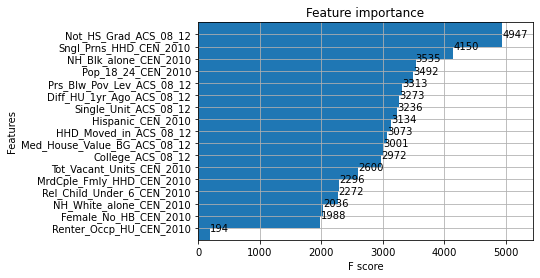

In [26]:
plot_importance(reg, height=2).set_yticklabels(['Renter_Occp_HU_CEN_2010','Female_No_HB_CEN_2010','NH_White_alone_CEN_2010','Rel_Child_Under_6_CEN_2010',\
                      'MrdCple_Fmly_HHD_CEN_2010','Tot_Vacant_Units_CEN_2010','College_ACS_08_12','Med_House_Value_BG_ACS_08_12',\
                      'HHD_Moved_in_ACS_08_12','Hispanic_CEN_2010','Single_Unit_ACS_08_12','Diff_HU_1yr_Ago_ACS_08_12',\
                      'Prs_Blw_Pov_Lev_ACS_08_12','Pop_18_24_CEN_2010','NH_Blk_alone_CEN_2010','Sngl_Prns_HHD_CEN_2010','Not_HS_Grad_ACS_08_12'])

In [48]:
predicted = reg.predict(X_test)

In [49]:
scores = r2_score(y_test,predicted) 
print("The R2 of the XGBoost Model is ",scores)

The R2 of the XGBoost Model is  0.5740037454844984


# Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [3]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

NameError: name 'X_train' is not defined

In [28]:
y_pred=rf.predict(X_test)

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 4.094660874922982
Mean Squared Error: 33.38319807119531
Root Mean Squared Error: 5.7778194910532905
R2 Score: 0.5569273248411765


In [55]:
#Sample Decision tree Regressor to Visualise the tree structure
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
from sklearn.tree import export_graphviz  
  
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
export_graphviz(clf, out_file ='tree.dot')

In [59]:
!pip install graphviz
from graphviz import Digraph

In [61]:
!pip install pydot

In [62]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

/bin/bash: dot: command not found


# ML Flow Implementation

https://mlflow.org/

 MLflow is an open source platform for managing the end-to-end machine learning lifecycle. It tackles four primary functions:
        
 1. Tracking experiments to record and compare parameters and results (MLflow Tracking).

 2. Packaging ML code in a reusable, reproducible form in order to share with other data scientists or transfer to production (MLflow Projects).

 3. Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).

 4. Providing a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations (MLflow Model Registry).

Default ML Flow UX shows model runs, input params and output result metrics. It also supports model coomparison on a flexible basis.

In [7]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import *

Launch mlflow server on commandline

In [29]:
!mlflow server --default-artifact-root ./mlflow/mlflow/0 -h 0.0.0.0

[2020-10-05 20:56:27 +0000] [269] [INFO] Starting gunicorn 20.0.4
[2020-10-05 20:56:27 +0000] [269] [INFO] Listening at: http://0.0.0.0:5000 (269)
[2020-10-05 20:56:27 +0000] [269] [INFO] Using worker: sync
[2020-10-05 20:56:27 +0000] [272] [INFO] Booting worker with pid: 272
[2020-10-05 20:56:27 +0000] [273] [INFO] Booting worker with pid: 273
[2020-10-05 20:56:27 +0000] [274] [INFO] Booting worker with pid: 274
[2020-10-05 20:56:27 +0000] [275] [INFO] Booting worker with pid: 275
^C
[2020-10-05 21:01:23 +0000] [269] [INFO] Handling signal: int
[2020-10-05 21:01:23 +0000] [273] [INFO] Worker exiting (pid: 273)
[2020-10-05 21:01:23 +0000] [274] [INFO] Worker exiting (pid: 274)
[2020-10-05 21:01:23 +0000] [272] [INFO] Worker exiting (pid: 272)
[2020-10-05 21:01:23 +0000] [275] [INFO] Worker exiting (pid: 275)


# Elastic Net Model

In [21]:
remote_server_uri = "http://mlflowui:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.get_artifact_uri()   

'./mlruns/0/5a9346f767d84001ac45477c897f6cb5/artifacts'

In [22]:
# Run from the root of MLflow
def train(in_alpha, in_l1_ratio):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import ElasticNet

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # The predicted column is "quality" which is a scalar from [3, 9]
    train_x = Feature_Set
    test_x = Feature_Set
    train_y = Dependent_Variable
    test_y = Dependent_Variable

    # Set default values if no alpha is provided
    if float(in_alpha) is None:
        alpha = 0.5
    else:
        alpha = float(in_alpha)

    # Set default values if no l1_ratio is provided
    if float(in_l1_ratio) is None:
        l1_ratio = 0.5
    else:
        l1_ratio = float(in_l1_ratio)

    # Useful for multiple runs (only doing one run in this sample notebook)    
    with mlflow.start_run(run_name="Elastic_Net_Model_Undercount_xmode_High_Sample"):
        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        # Evaluate Metrics
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_param("Coefficeients",lr.coef_)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(lr, "model")

In [23]:
#Taking alpha as 0.5, and l1 ratio as 0.5

train(0.5,0.5)

Exception: Run with UUID 5a9346f767d84001ac45477c897f6cb5 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

# XG Boost_MLFlow

In [12]:
remote_server_uri = "http://mlflowui:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  

train_features=X_train
train_labels=y_train
test_features=X_test
test_labels=y_test
print(remote_server_uri)

http://mlflowui:5000


{'f0': 4076, 'f2': 3007, 'f17': 2856, 'f16': 2139, 'f20': 1382, 'f11': 2099, 'f9': 3536, 'f3': 1555, 'f6': 2808, 'f4': 2062, 'f1': 2942, 'f10': 2696, 'f15': 2007, 'f21': 1427, 'f12': 2381, 'f5': 3134, 'f18': 1473, 'f14': 2338, 'f13': 2134, 'f8': 1364, 'f22': 1053, 'f19': 1991, 'f7': 37}
R2_Score:  0.5955591458070284
.mlruns/mlruns/0/638568605c98473a819aa414d936cebc/artifacts


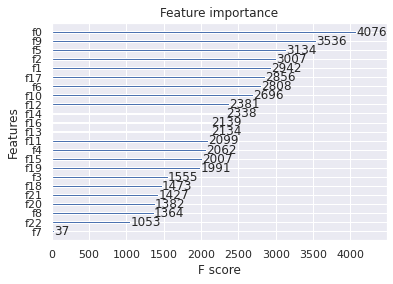

In [13]:
mlflow.end_run()

with mlflow.start_run(run_name="XGBoost_Undercount_High_Sample") as run:
        
    # model parameters
    params = {'learning_rate': 0.01, 'n_estimators': 1000, 'seed': 10,
                  'objective': 'reg:squarederror', 'gamma':1}

    # log model params
    for key in params:
        mlflow.log_param(key, params[key])

    # train XGBoost model
    gbtree = XGBRegressor(**params)
    gbtree.fit(train_features, train_labels)

    importances = gbtree.get_booster().get_fscore()
    print(importances)

    # get predictions
    y_pred = gbtree.predict(test_features)

    r2 = r2_score(test_labels, y_pred)
    print("R2_Score: ", r2)
    
    # log accuracy metric
    mlflow.log_metric("r2", r2)

    sns.set(font_scale=1)
    xgb.plot_importance(gbtree)
    plt.savefig("importance.png", dpi = 200, bbox_inches = "tight")
    run_id=run.info.run_id
    arti='.mlruns/mlruns/0/'+run_id+'/artifacts'
    print(arti)
    mlflow.log_artifact("importance.png",artifact_path=arti)
    #artifact_path = mlflow.get_artifact_uri()

    # log model
    mlflow.sklearn.log_model(gbtree, "model")

In [15]:
print(artifact_path)

./mlruns/0/69b78653420548e28d9adbbb1b408b1f/artifacts


# Random Forest ML Flow

In [16]:
print(mlflow.get_tracking_uri())

http://mlflowui:5000


In [48]:
with mlflow.start_run(run_name="Random_Forest_Undercount_xmode"):    
    from sklearn.ensemble import RandomForestRegressor
    
    # model parameters
    params = {'n_estimators': 1000, 'random_state': 41}

    # log model params
    for key in params:
        mlflow.log_param(key, params[key])

    # train Random Forest model
    RFtree = RandomForestRegressor(**params)
    RFtree.fit(train_features, train_labels)

    # get predictions
    y_pred = RFtree.predict(test_features)

    R2_score = r2_score(test_labels, y_pred)
    print("R2_Score: ", R2_score)
    
    # log accuracy metric
    mlflow.log_metric("r2", R2_score)
    
    # log model
    mlflow.sklearn.log_model(RFtree, "model")

KeyboardInterrupt: 